In [1]:
import pandas as pd

file_path = 'data/Supplemental_Data_Raw_Genecounts.csv'

# Load the CSV file into a DataFrame.
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 17', axis=1)
df = df.rename(columns={"Unnamed: 0": "mnra",})
df.set_index('mnra', inplace=True)
# Convert every non-index column to int
df = df.apply(pd.to_numeric, errors='coerce', downcast='integer')

# Pruning rows where all the values are 0.
# Assuming that you have columns 'x' and 'y', replace them with the actual names of your columns.
print(df.shape)
df = df[(df.loc[:, df.columns != 'index'] != 0).any(axis=1)]


(24411, 32)


In [2]:
# Pruning rows where all the values in columns_to_check are 0.
df = df[(df != 0).any(axis=1)]

In [3]:
df.shape

(20877, 32)

In [4]:
df.columns

Index(['A1.1.1', 'A1.1.2', 'A1.1.3', 'A1.1.4', 'A2.1.1', 'A2.1.2', 'A2.1.3',
       'A2.1.4', 'A2.2.1', 'A2.2.2', 'A2.2.3', 'A2.2.4', 'A2.3.1', 'A2.3.2',
       'A2.3.3', 'A2.3.4', 'B1.1.1', 'B1.1.2', 'B1.1.3', 'B1.1.4', 'B2.1.1',
       'B2.1.2', 'B2.1.3', 'B2.1.4', 'B2.2.1', 'B2.2.2', 'B2.2.3', 'B2.2.4',
       'B2.3.1', 'B2.3.2', 'B2.3.3', 'B2.3.4'],
      dtype='object')

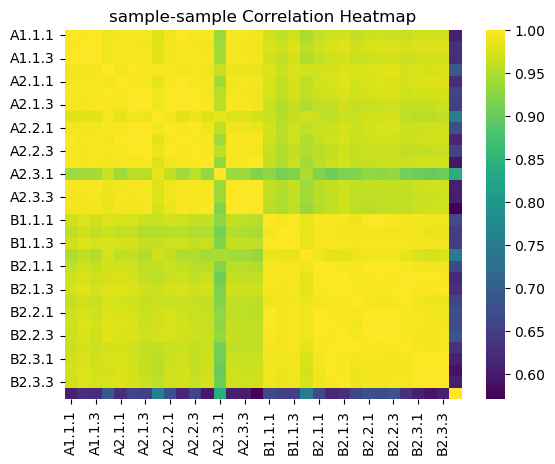

In [5]:
# Step 1: Calculate pairwise correlation
correlation_matrix = df.corr(method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('sample-sample Correlation Heatmap')
plt.show()

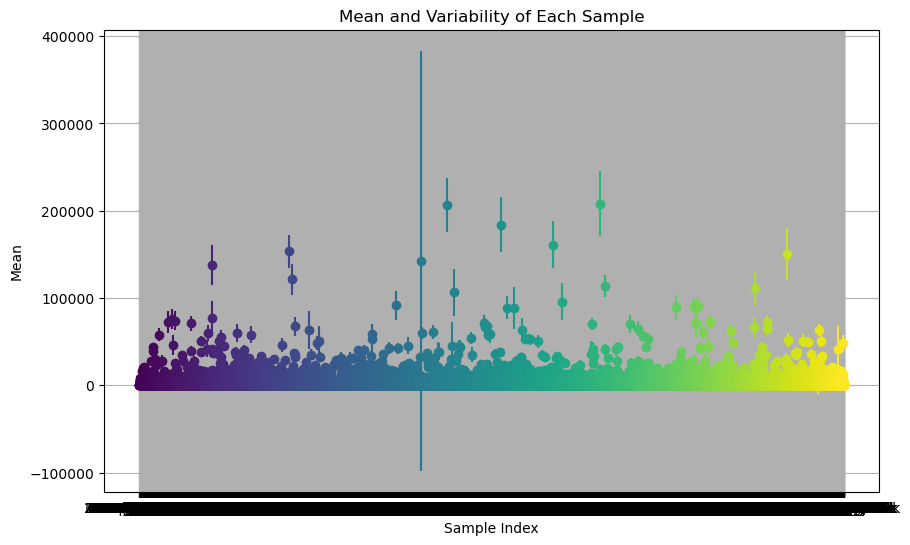

In [6]:
import matplotlib.pyplot as plt

# Calculating the mean and standard deviation for each row
df['mean'] = df.mean(axis=1)
df['std'] = df.std(axis=1)
df['cv'] = (df.std(axis=1) / df.mean(axis=1)).abs() * 100

import numpy as np

# Generate a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

plt.figure(figsize=(10, 6))
for idx, color in zip(df.index, colors):
    plt.errorbar(idx, df.loc[idx, 'mean'], yerr=df.loc[idx, 'std'], fmt='o', color=color)

plt.title('Mean and Variability of Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Mean')
plt.grid(True)
plt.show()

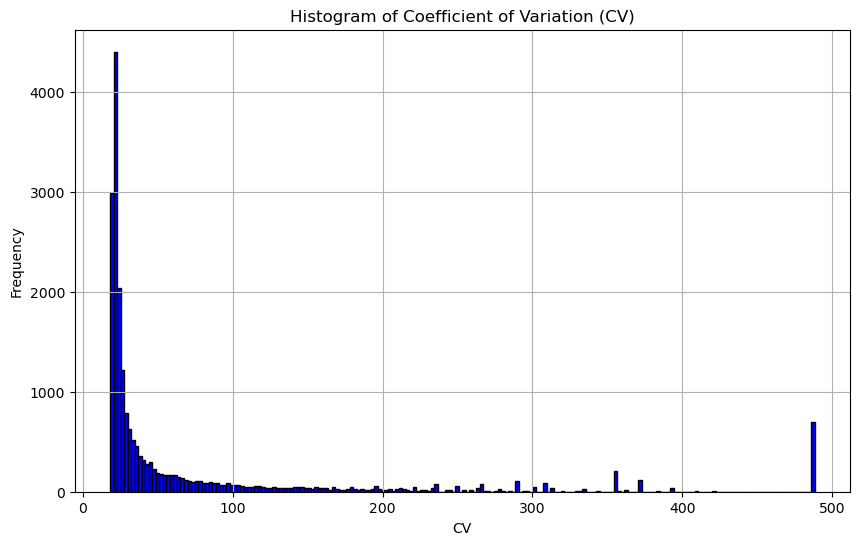

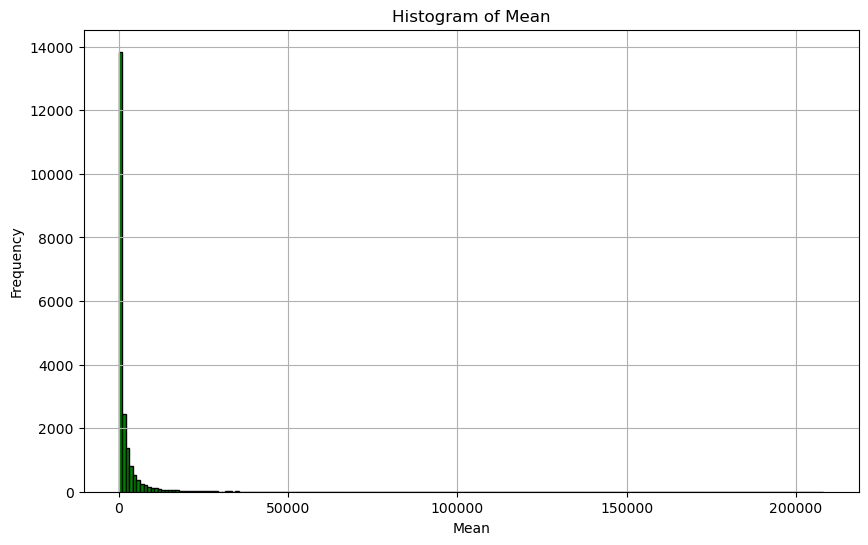

In [7]:
# Plotting histogram for df['cv']
plt.figure(figsize=(10,6))
plt.hist(df['cv'], bins=200, color='blue', edgecolor='black')
plt.title('Histogram of Coefficient of Variation (CV)')
plt.xlabel('CV')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting histogram for df['mean']
plt.figure(figsize=(10,6))
plt.hist(df['mean'], bins=200, color='green', edgecolor='black')
plt.title('Histogram of Mean')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Differential expression analysis

### Pairwise

In [ ]:
from statsmodels.stats import multitest
from scipy import stats
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Define the function to perform the t-test for a given pair of conditions and a given gene
def perform_ttest(condition_1, condition_2, gene_row):
    condition_1_data = gene_row[condition_1]
    condition_2_data = gene_row[condition_2]
    
    # If the variance is zero for both conditions, skip the t-test
    if np.var([condition_1_data]) == 0 and np.var([condition_2_data]) == 0:
        return {
            'condition_1': condition_1,
            'condition_2': condition_2,
            'gene': gene_row.name,
            'mean_condition_1': condition_1_data,
            'mean_condition_2': condition_2_data,
            'p_value': np.nan  # or return some default p_value, like 1.0
        }
    
    # Compute the mean expression level for each condition
    mean_condition_1 = np.mean(condition_1_data)
    mean_condition_2 = np.mean(condition_2_data)
    
    # Perform a t-test between the two conditions
    t_stat, p_value = stats.ttest_ind([condition_1_data], [condition_2_data], equal_var=False, nan_policy='omit')
    
    return {
        'condition_1': condition_1,
        'condition_2': condition_2,
        'gene': gene_row.name,
        'mean_condition_1': mean_condition_1,
        'mean_condition_2': mean_condition_2,
        'p_value': p_value
    }

# Get all condition columns
condition_columns = df.columns


# Create a list to store the tasks
tasks = []

# Initialize the progress bar
total_combinations = len(list(itertools.combinations(condition_columns, 2))) * len(df.index)
progress_bar = tqdm(total=total_combinations, desc='Generating tasks', unit='task')

# Generate all tasks (pairs of conditions and genes) with progress update
for condition_1, condition_2 in itertools.combinations(condition_columns, 2):
    for gene in df.index:
        tasks.append((condition_1, condition_2, df.loc[gene]))
        progress_bar.update(1)

# Close the progress bar
progress_bar.close()


In [ ]:

# Perform the tasks in parallel with progress bar
results_list = Parallel(n_jobs=-1)(delayed(perform_ttest)(condition_1, condition_2, gene_row) for condition_1, condition_2, gene_row in tqdm(tasks, desc='Processing', unit='task'))

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Correct for multiple testing (optional)
results_df['adjusted_p_value'] = multitest.multipletests(results_df['p_value'], method='fdr_bh')[1]

# You can filter the results based on a significance threshold, e.g. adjusted p-value < 0.05
significant_results = results_df[results_df['adjusted_p_value'] < 0.05]


In [ ]:
results_df.columns

### A and B

In [8]:
from scipy import stats
import numpy as np
from statsmodels.stats import multitest


# Define the groups you want to compare
group_a_cols = [col for col in df.columns if 'A' in col]
group_b_cols = [col for col in df.columns if 'B' in col]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['gene', 'mean_group_a', 'mean_group_b', 'p_value'])

for index, row in df.iterrows():
    group_a_data = row[group_a_cols]
    group_b_data = row[group_b_cols]
    
    # Compute the mean expression level for each group
    mean_group_a = np.mean(group_a_data)
    mean_group_b = np.mean(group_b_data)
    
    # Perform a t-test between the two groups
    t_stat, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=False, nan_policy='omit')
    
    # Append the results to the results DataFrame
    new_row = pd.DataFrame({
        'gene': [index],
        'mean_group_a': [mean_group_a],
        'mean_group_b': [mean_group_b],
        'p_value': [p_value]
    })
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)


# Correct for multiple testing (optional)
results_df['adjusted_p_value'] = multitest.multipletests(results_df['p_value'], method='fdr_bh')[1]
results_df.set_index('gene', inplace=True)

# Define significance threshold
sig_threshold = 0.01


# Filter the results based on a significance threshold, for example, adjusted p-value < 0.01
significant_genes = results_df[results_df['adjusted_p_value'] < sig_threshold]

/var/folders/c9/p_q1xbbj7sv7nwvd_17c75lh0000gn/T/ipykernel_9850/2697467858.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [9]:
significant_genes.columns

Index(['mean_group_a', 'mean_group_b', 'p_value', 'adjusted_p_value'], dtype='object')

In [10]:
# Compute log2 fold change
results_df['log2_fold_change'] = np.log2(results_df['mean_group_b'] / results_df['mean_group_a'])

# Compute -log10 of the adjusted p-value
results_df['neg_log10_p_value'] = -np.log10(results_df['adjusted_p_value'])

/Users/tanguy/miniforge3/envs/transcriptome_env/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


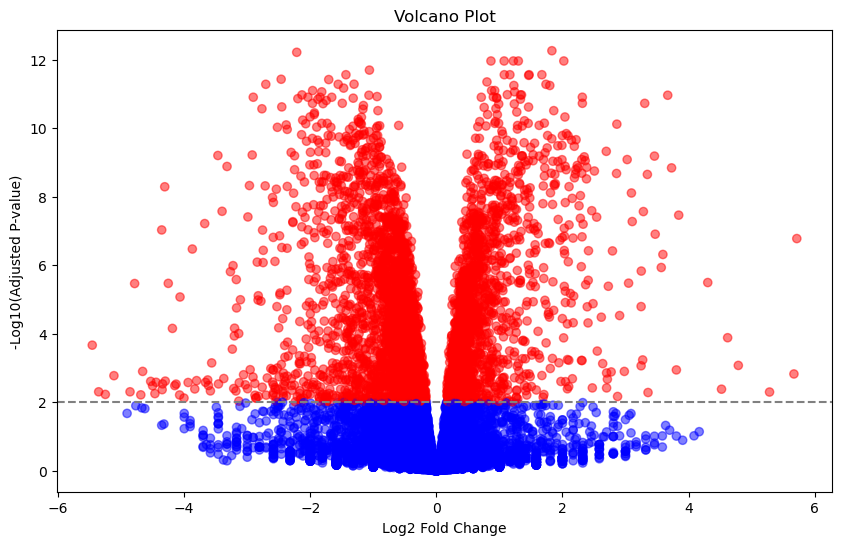

In [25]:
import matplotlib.pyplot as plt


# Create a figure and a set of subplots.
fig, ax = plt.subplots(figsize=(10, 6))

# Color significant points differently
colors = np.where(results_df['adjusted_p_value'] < sig_threshold, 'r', 'b')

# Scatter plot
ax.scatter(results_df['log2_fold_change'], results_df['neg_log10_p_value'], c=colors, alpha=0.5)

# Title and labels
ax.set_title('Volcano Plot')
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('-Log10(Adjusted P-value)')

# Draw horizontal line to show the significance threshold
ax.axhline(y=-np.log10(sig_threshold), linestyle='--', color='grey')

# Show the plot
plt.show()


## comparing with CV genes

In [12]:

# Step 1: Get the same number of rows from df with the highest 'cv' values
top_cv_genes_df = df.nlargest(significant_genes.shape[0], 'cv')

# Step 2: Compare the genes (indexes) from the two DataFrames and find the common ones
common_genes = set(significant_genes.index).intersection(set(top_cv_genes_df.index))

# Print the common genes
print(f"Top CV genes: {len(top_cv_genes_df)}")

print(f"Differential expression analysis genes: {significant_genes.shape[0]}")

print(f"Common genes between significant genes and top CV genes: {len(common_genes)}")


Top CV genes: 4859
Differential expression analysis genes: 4859
Common genes between significant genes and top CV genes: 386


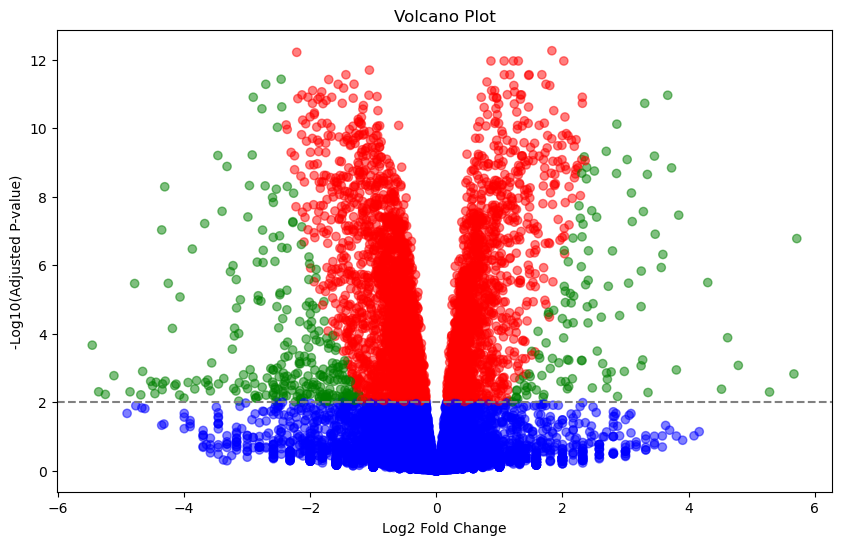

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a set of subplots.
fig, ax = plt.subplots(figsize=(10, 6))

# Initialize an empty list to store the colors
colors = []

# Iterate over the rows of the DataFrame and assign colors
for idx, row in results_df.iterrows():
    if idx in common_genes:
        colors.append('green')  # Green for genes in common_genes
    elif row['adjusted_p_value'] < sig_threshold:
        colors.append('r')  # Red for significant genes
    else:
        colors.append('b')  # Blue for other genes

# Scatter plot
ax.scatter(results_df['log2_fold_change'], results_df['neg_log10_p_value'], c=colors, alpha=0.5)

# Title and labels
ax.set_title('Volcano Plot')
ax.set_xlabel('Log2 Fold Change')
ax.set_ylabel('-Log10(Adjusted P-value)')

# Draw horizontal line to show the significance threshold
ax.axhline(y=-np.log10(sig_threshold), linestyle='--', color='grey')

# Show the plot
plt.show()

# 

# Clustering

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Extract rows corresponding to common_genes from df
common_genes_df = df.loc[list(common_genes)]

# Step 2: Standardize the data
scaler = StandardScaler()
standardized_data = scaler.fit_transform(common_genes_df.T)  # Transposing as we want to standardize the features (genes)

In [15]:
common_genes_df.columns

Index(['A1.1.1', 'A1.1.2', 'A1.1.3', 'A1.1.4', 'A2.1.1', 'A2.1.2', 'A2.1.3',
       'A2.1.4', 'A2.2.1', 'A2.2.2', 'A2.2.3', 'A2.2.4', 'A2.3.1', 'A2.3.2',
       'A2.3.3', 'A2.3.4', 'B1.1.1', 'B1.1.2', 'B1.1.3', 'B1.1.4', 'B2.1.1',
       'B2.1.2', 'B2.1.3', 'B2.1.4', 'B2.2.1', 'B2.2.2', 'B2.2.3', 'B2.2.4',
       'B2.3.1', 'B2.3.2', 'B2.3.3', 'B2.3.4', 'mean', 'std', 'cv'],
      dtype='object')

In [16]:
import pandas as pd
from sklearn.cluster import HDBSCAN

# Create a DBSCAN object with specific epsilon and minimum samples
hdbscan = HDBSCAN(min_samples=3)

# Fit the model to the scaled data
clustering_labels = hdbscan.fit_predict(standardized_data.T)

# Attach the DBSCAN labels to the filtered DataFrame
common_genes_df.insert(0, "clustering_labels", pd.Series(clustering_labels, index=common_genes_df.index))
common_genes_df.columns

Index(['clustering_labels', 'A1.1.1', 'A1.1.2', 'A1.1.3', 'A1.1.4', 'A2.1.1',
       'A2.1.2', 'A2.1.3', 'A2.1.4', 'A2.2.1', 'A2.2.2', 'A2.2.3', 'A2.2.4',
       'A2.3.1', 'A2.3.2', 'A2.3.3', 'A2.3.4', 'B1.1.1', 'B1.1.2', 'B1.1.3',
       'B1.1.4', 'B2.1.1', 'B2.1.2', 'B2.1.3', 'B2.1.4', 'B2.2.1', 'B2.2.2',
       'B2.2.3', 'B2.2.4', 'B2.3.1', 'B2.3.2', 'B2.3.3', 'B2.3.4', 'mean',
       'std', 'cv'],
      dtype='object')

In [17]:
np.unique(clustering_labels)

array([-1,  0,  1,  2,  3])

In [18]:
# Perform PCA on the standardized data
pca = PCA(n_components=0.9, svd_solver='full')
pca_model = pca.fit(standardized_data.T)
principalComponents = pca_model.transform(standardized_data.T)

pc_df = pd.DataFrame(principalComponents, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
pc_df.insert(0, "clustering_labels", pd.Series(clustering_labels))

In [19]:
pca.n_components_

6

In [20]:
pc_df['clustering_labels'].unique()

array([ 2, -1,  3,  0,  1])

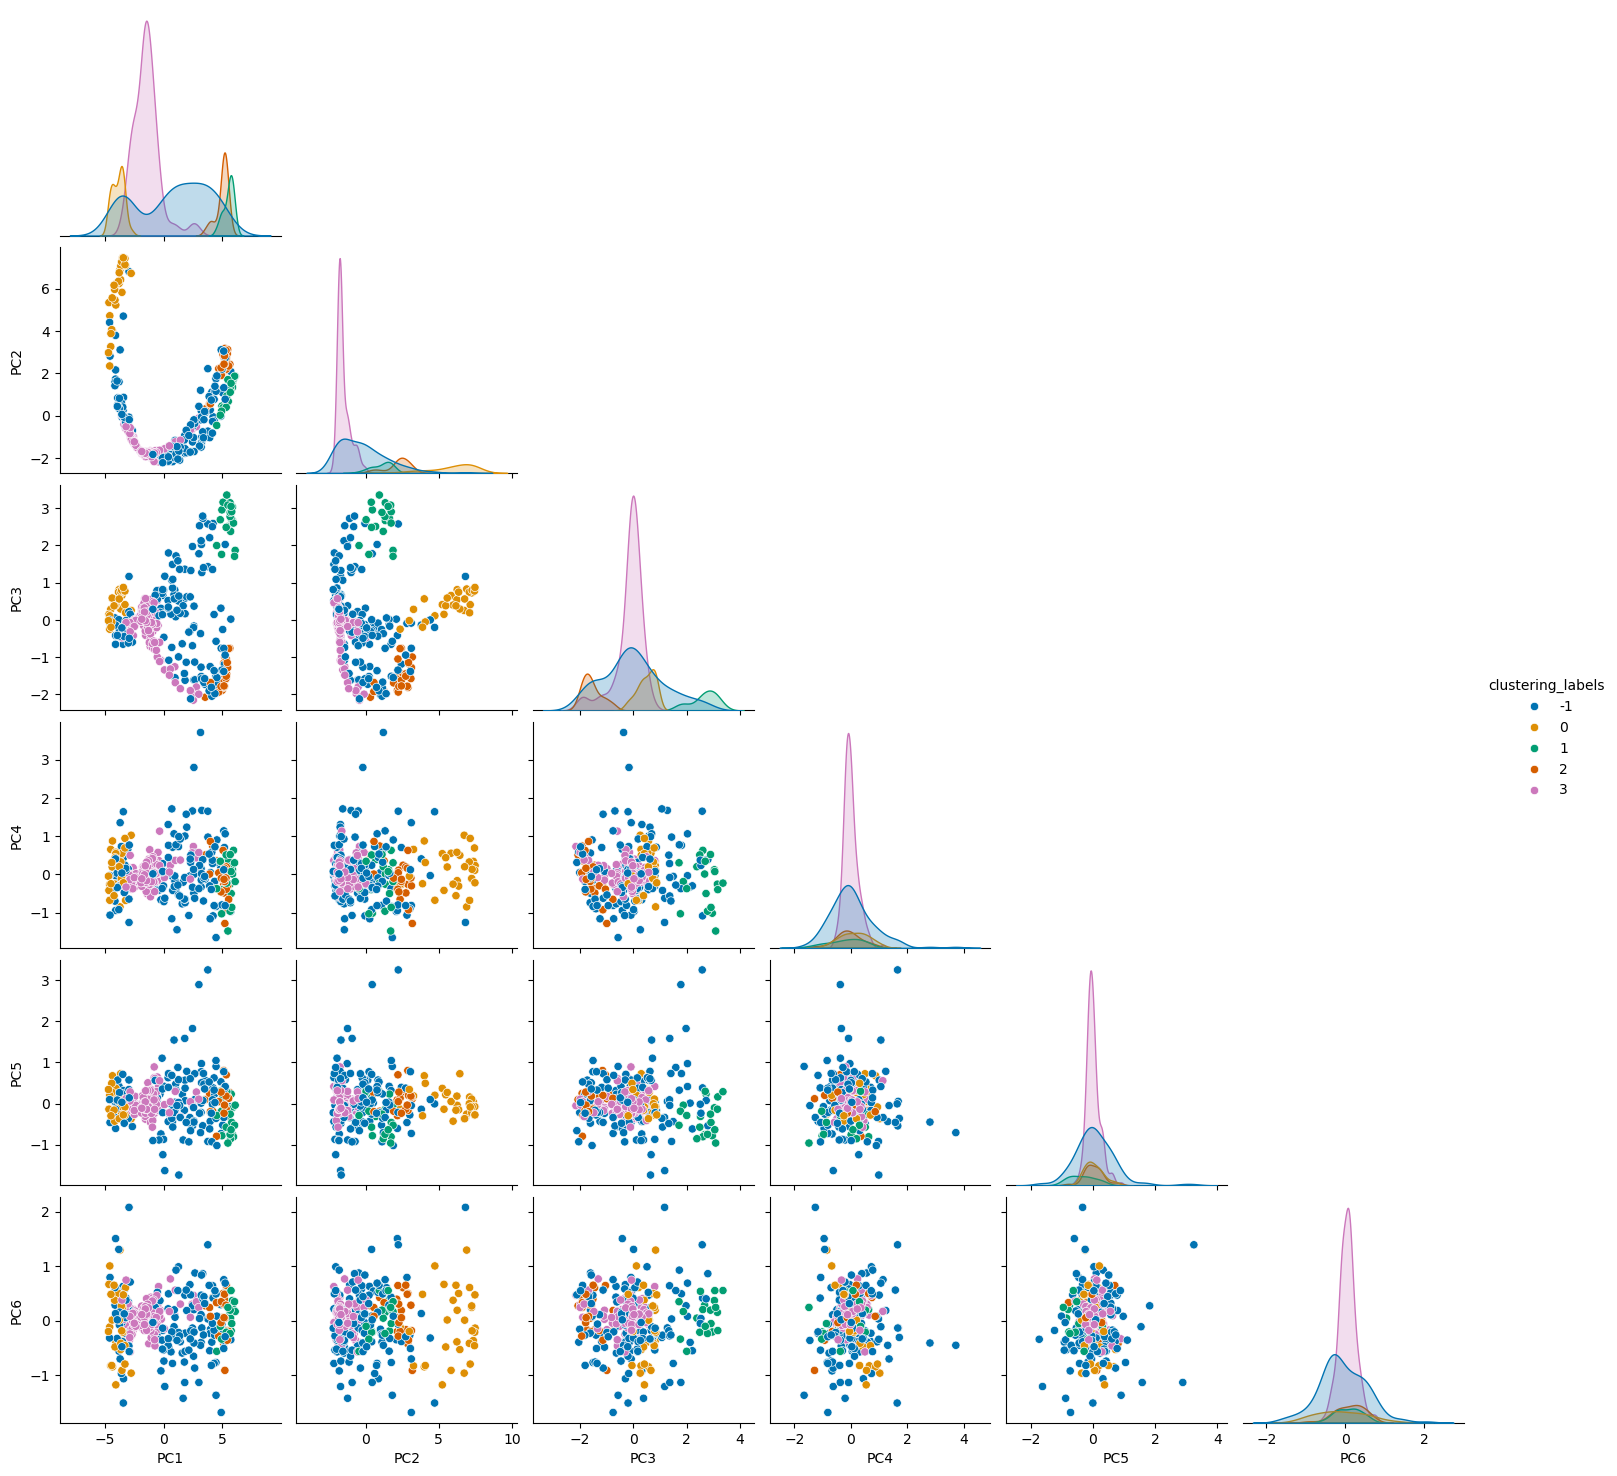

In [21]:

# Set the color palette as needed
palette = sns.color_palette("colorblind", len(set(clustering_labels)))

# Create the pairplot colored by clustering_labels
sns.pairplot(pc_df, hue='clustering_labels', palette=palette, diag_kind='kde', corner=True)
plt.show()

In [22]:
common_genes_df[common_genes_df["clustering_labels"]== 4]

,clustering_labels,A1.1.1,A1.1.2,A1.1.3,A1.1.4,A2.1.1,A2.1.2,A2.1.3,A2.1.4,A2.2.1,...,B2.2.2,B2.2.3,B2.2.4,B2.3.1,B2.3.2,B2.3.3,B2.3.4,mean,std,cv
mnra,,,,,,,,,,,,,,,,,,,,,


In [23]:
np.unique(clustering_labels)

array([-1,  0,  1,  2,  3])

# Graphs

In [24]:
# Replace this with your actual DataFrame.
# common_genes_df = pd.DataFrame(...)

# Exclude non-sample columns for correlation computation
samples_df = common_genes_df.drop(columns=['mean', 'std', 'cv'])

# Compute the correlation matrix
corr_matrix = samples_df.T.corr()

# Perform hierarchical clustering
Z = linkage(corr_matrix, 'ward')

NameError: name 'linkage' is not defined